<a href="https://colab.research.google.com/github/nandy-101/AI-Powered-Sentimental-Analysis-for-ChatGPT-Reviews/blob/main/SentimentAnalysisReviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI-Powered Sentiment Analysis for ChatGPT Reviews

Installs + Imports

In [ ]:
# Cell 1: Setup - installs and imports
# Run once at the top of the notebook.


!pip install -q wordcloud vaderSentiment sentence-transformers xgboost streamlit pycountry

# Standard imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import datetime

# NLP & ML
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab') # Download punkt_tab
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import joblib

# Optional heavier libs
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sentence_transformers import SentenceTransformer
import xgboost as xgb

# plotting style
sns.set(style='whitegrid', palette='muted', rc={'figure.figsize':(10,6)})

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 117.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 124.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 134.6 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Load dataset

In [ ]:
# Cell 2: Load the dataset - change path if necessary
DATA_PATH = '/content/chatgpt_style_reviews_dataset.xlsx'
df = pd.read_excel(DATA_PATH)
print("Loaded dataset with shape:", df.shape)
display(df.head())


Loaded dataset with shape: (250, 12)


,date,title,review,rating,username,helpful_votes,review_length,platform,language,location,version,verified_purchase
0,2024-09-06 00:00:00,Claim who accept.,Every quite sense including six lot have never...,4,morrowthomas,30,22,Flipkart,ar,Nepal,3.8.4,No
1,2025-03-07 00:00:00,Growth pretty wish.,Ask develop bag also his worker pass. Expert w...,4,sheakimberly,120,22,Flipkart,ar,Guinea,5.2.6,Yes
2,########,What then spend offer reason whom none.,If customer address region try near risk next ...,5,katherineali,130,21,Flipkart,es,Kuwait,3.6.5,No
3,########,Say dog drug enter director strong student.,To television loss election him small detail r...,1,eric11,72,26,Amazon,pt,Uruguay,5.7.2,No
4,########,Purpose here beyond.,Pass share must amount lot per manage world to...,5,chloe42,123,27,Amazon,zh,Mayotte,5.8.6,No


Quick data inspection & initial cleaning

In [ ]:
# Cell 3: Inspect basic info, missing values, dtypes
df.info()
display(df.describe(include='all').T)

# Standardize column names (lowercase, underscores)
df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               250 non-null    object
 1   title              250 non-null    object
 2   review             250 non-null    object
 3   rating             250 non-null    int64 
 4   username           250 non-null    object
 5   helpful_votes      250 non-null    int64 
 6   review_length      250 non-null    int64 
 7   platform           250 non-null    object
 8   language           250 non-null    object
 9   location           250 non-null    object
 10  version            250 non-null    object
 11  verified_purchase  250 non-null    object
dtypes: int64(3), object(9)
memory usage: 23.6+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date,250,47,########,192,NaN,NaN,NaN,NaN,NaN,NaN,NaN
title,250,250,Claim who accept.,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review,250,250,Every quite sense including six lot have never...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,250.0,NaN,NaN,NaN,2.98,1.465671,1.0,2.0,3.0,4.0,5.0
username,250,250,morrowthomas,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
helpful_votes,250.0,NaN,NaN,NaN,94.416,57.020842,0.0,42.25,95.0,140.5,200.0
review_length,250.0,NaN,NaN,NaN,20.852,3.459185,13.0,18.0,21.0,23.0,29.0
platform,250,5,Amazon,56,NaN,NaN,NaN,NaN,NaN,NaN,NaN
language,250,10,ru,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location,250,157,Congo,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,date,title,review,rating,username,helpful_votes,review_length,platform,language,location,version,verified_purchase
0,2024-09-06 00:00:00,Claim who accept.,Every quite sense including six lot have never...,4,morrowthomas,30,22,Flipkart,ar,Nepal,3.8.4,No
1,2025-03-07 00:00:00,Growth pretty wish.,Ask develop bag also his worker pass. Expert w...,4,sheakimberly,120,22,Flipkart,ar,Guinea,5.2.6,Yes
2,########,What then spend offer reason whom none.,If customer address region try near risk next ...,5,katherineali,130,21,Flipkart,es,Kuwait,3.6.5,No
3,########,Say dog drug enter director strong student.,To television loss election him small detail r...,1,eric11,72,26,Amazon,pt,Uruguay,5.7.2,No
4,########,Purpose here beyond.,Pass share must amount lot per manage world to...,5,chloe42,123,27,Amazon,zh,Mayotte,5.8.6,No


Handle missing values & basic fixes

In [ ]:
# Cell 4: Handle missing values
# Columns from doc: date, title, review, rating, username, helpful_votes, review_length, platform, language, location, version, verified_purchase

# Convert date
try:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
except Exception as e:
    print("date parse error:", e)

# Fill missing reviews with empty string
df['review'] = df['review'].fillna('').astype(str)

# For helpful_votes and rating, coerce to numeric
df['helpful_votes'] = pd.to_numeric(df['helpful_votes'], errors='coerce').fillna(0).astype(int)
df['rating'] = pd.to_numeric(df['rating'], errors='coerce').fillna(0).astype(int)

# review_length if not present, compute from review text (chars)
if 'review_length' not in df.columns or df['review_length'].isnull().all():
    df['review_length'] = df['review'].apply(len)

# platform and verified_purchase clean
df['platform'] = df['platform'].fillna('Unknown').astype(str)
df['verified_purchase'] = df['verified_purchase'].fillna('No').astype(str)

# language and location cleanup
df['language'] = df['language'].fillna('en')
df['location'] = df['location'].fillna('Unknown')

print("After cleaning, shape:", df.shape)
df.isnull().sum()


After cleaning, shape: (250, 12)


,0
date,192
title,0
review,0
rating,0
username,0
helpful_votes,0
review_length,0
platform,0
language,0
location,0


Create sentiment labels from rating (target variable)

In [ ]:
# Cell 5: Map ratings to sentiment labels (for supervised training)
# 4-5 -> Positive, 3 -> Neutral, 1-2 -> Negative
def rating_to_sentiment(r):
    if r >= 4:
        return 'positive'
    elif r == 3:
        return 'neutral'
    elif r > 0:
        return 'negative'
    else:
        return 'unknown'

df['rating_sentiment'] = df['rating'].apply(rating_to_sentiment)
df['rating_sentiment'].value_counts()


,count
rating_sentiment,
negative,97
positive,96
neutral,57


Text preprocessing - tokenize, lowercase, remove stopwords, lemmatize

In [ ]:

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')  # <-- this is the new one
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Cell 6: Text cleaning function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

# Apply cleaning to a new column
df['clean_review'] = df['review'].apply(clean_text)
df[['review','clean_review']].head(3)


,review,clean_review
0,Every quite sense including six lot have never...,every quite sense including six lot never effe...
1,Ask develop bag also his worker pass. Expert w...,ask develop bag also worker pas expert white a...
2,If customer address region try near risk next ...,customer address region try near risk next gir...


Saving cleaned dataset

In [ ]:
# Cell 7: Save cleaned & preprocessed dataset (deliverable)
CLEAN_PATH = '/content/clean_chatgpt_reviews.csv'
df.to_csv(CLEAN_PATH, index=False)
print("Saved cleaned dataset to:", CLEAN_PATH)


Saved cleaned dataset to: /content/clean_chatgpt_reviews.csv


**Exploratory Data Analysis**

Distribution of review ratings (bar chart 1-5)

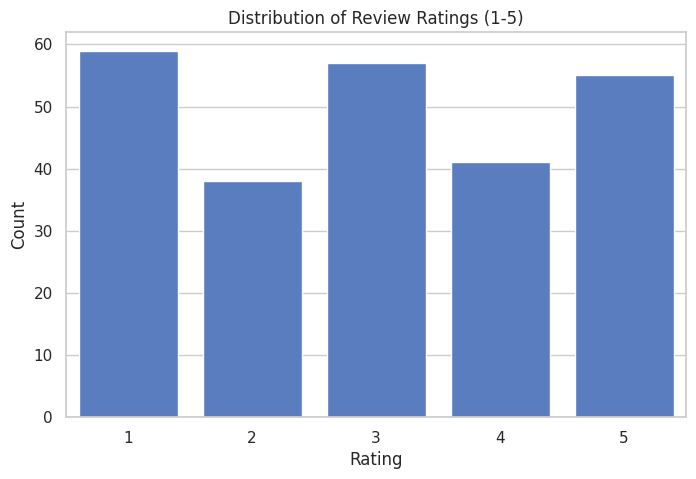

In [ ]:
# Cell 8: Rating distribution (1 to 5)
plt.figure(figsize=(8,5))
sns.countplot(data=df[df['rating']>0], x='rating', order=sorted(df['rating'].unique()))
plt.title('Distribution of Review Ratings (1-5)')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


Helpful reviews above threshold (e.g., >10 helpful votes)

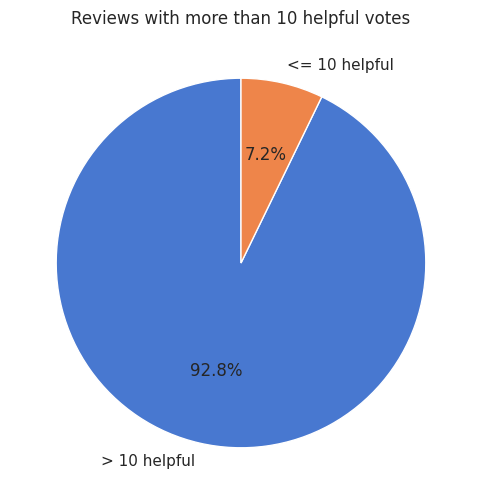

Total reviews: 250, >10 helpful: 232


In [ ]:
# Cell 9: Count of reviews above a helpful threshold
THRESH = 10
above = df[df['helpful_votes'] > THRESH].shape[0]
below = df.shape[0] - above
plt.figure(figsize=(6,6))
plt.pie([above, below], labels=[f'> {THRESH} helpful', f'<= {THRESH} helpful'], autopct='%1.1f%%', startangle=90)
plt.title(f'Reviews with more than {THRESH} helpful votes')
plt.show()

print(f"Total reviews: {df.shape[0]}, >{THRESH} helpful: {above}")


Wordclouds for positive (4-5) vs negative (1-2)

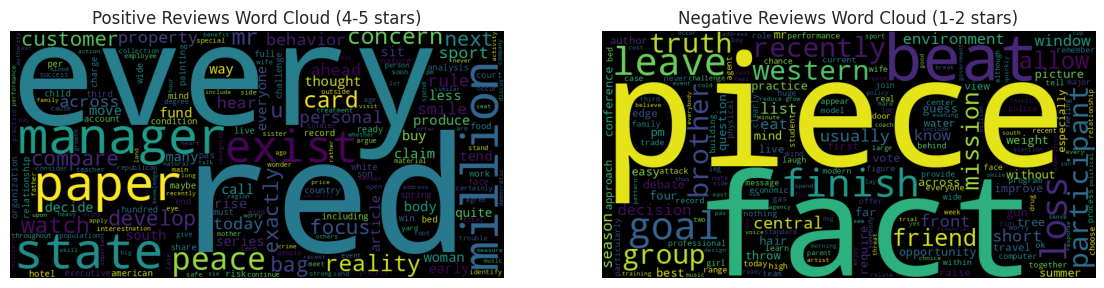

In [ ]:
# Cell 10: Word clouds positive vs negative
pos_text = " ".join(df[df['rating']>=4]['clean_review'].dropna().values)
neg_text = " ".join(df[df['rating']<=2]['clean_review'].dropna().values)

wc_common = set(list(STOPWORDS))
wc = WordCloud(width=800, height=400, stopwords=wc_common, collocations=False).generate(pos_text)
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=800,height=400,stopwords=wc_common,collocations=False).generate(pos_text))
plt.axis('off')
plt.title('Positive Reviews Word Cloud (4-5 stars)')

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=800,height=400,stopwords=wc_common,collocations=False).generate(neg_text))
plt.axis('off')
plt.title('Negative Reviews Word Cloud (1-2 stars)')
plt.show()


Average rating over time (line chart by month)

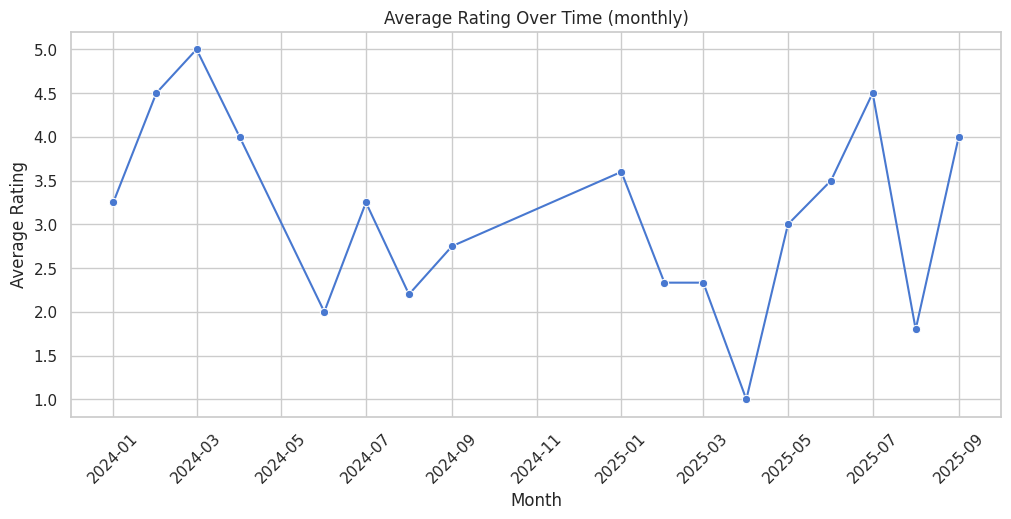

In [ ]:
# Cell 11: Avg rating change over time (monthly)
df_time = df.dropna(subset=['date']).copy()
df_time['month'] = df_time['date'].dt.to_period('M')
monthly = df_time.groupby('month')['rating'].mean().reset_index()
monthly['month'] = monthly['month'].dt.to_timestamp()

plt.figure(figsize=(12,5))
sns.lineplot(data=monthly, x='month', y='rating', marker='o')
plt.title('Average Rating Over Time (monthly)')
plt.xlabel('Month')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.show()


Ratings by user location (top countries)

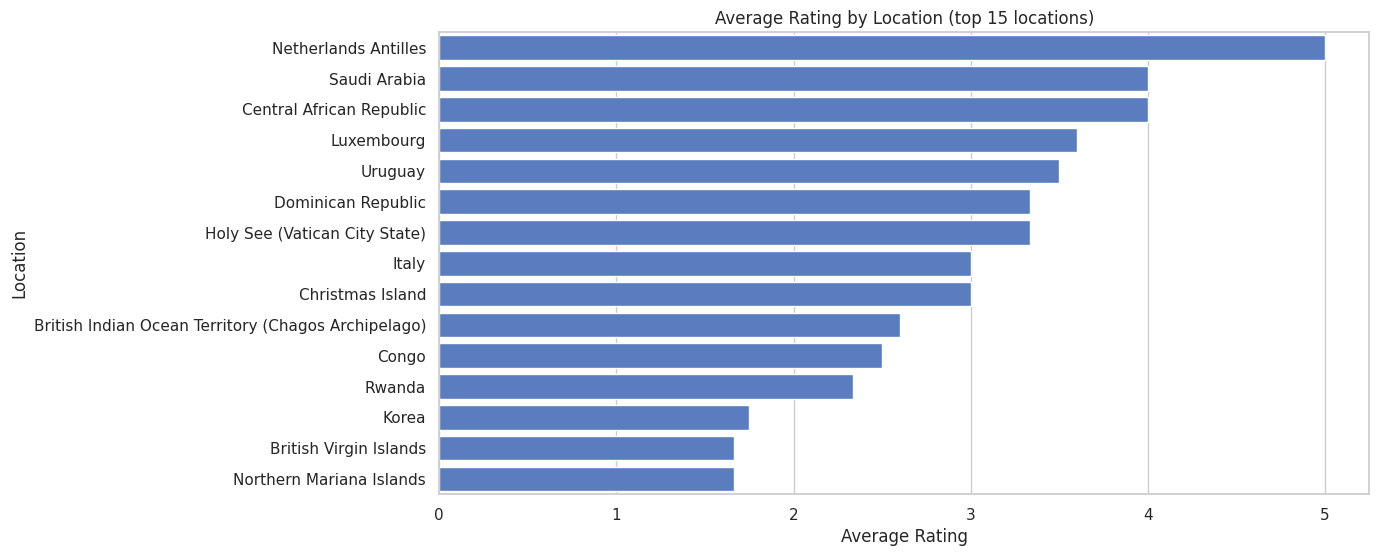

In [ ]:
# Cell 12: Ratings by location (top 15 locations by count)
loc_counts = df['location'].value_counts().head(15).index.tolist()
sub = df[df['location'].isin(loc_counts)]
loc_avg = sub.groupby('location')['rating'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=loc_avg, x='rating', y='location')
plt.title('Average Rating by Location (top 15 locations)')
plt.xlabel('Average Rating')
plt.ylabel('Location')
plt.show()


Platform comparison (Web vs Mobile)

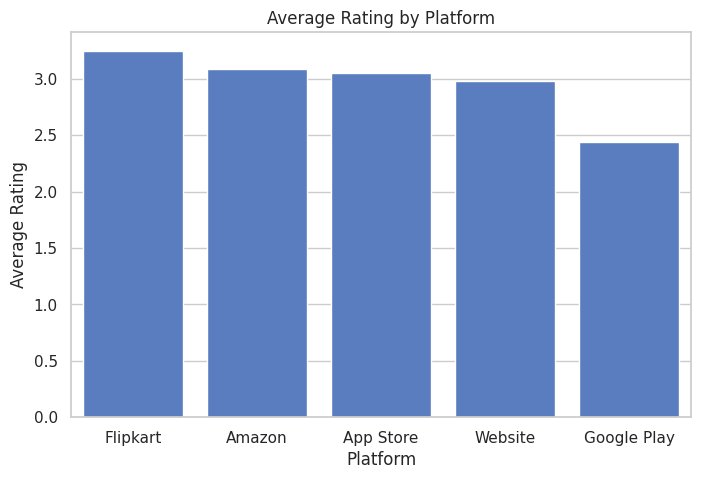

,platform,count,mean
0,Flipkart,44,3.250000
1,Amazon,56,3.089286
2,App Store,55,3.054545
3,Website,54,2.981481
4,Google Play,41,2.439024


In [ ]:
# Cell 13: Platform comparison - avg rating
platform_avg = df.groupby('platform')['rating'].agg(['count','mean']).sort_values('mean', ascending=False).reset_index()
plt.figure(figsize=(8,5))
sns.barplot(data=platform_avg, x='platform', y='mean', order=platform_avg['platform'])
plt.title('Average Rating by Platform')
plt.ylabel('Average Rating')
plt.xlabel('Platform')
plt.show()
display(platform_avg)


Verified vs Non-verified average rating

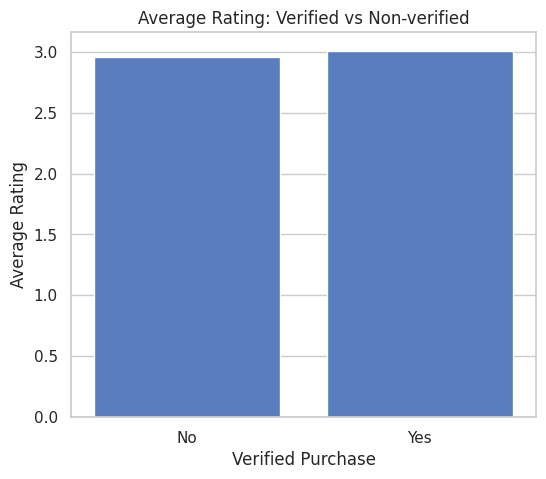

,verified_purchase,count,mean
0,No,134,2.955224
1,Yes,116,3.008621


In [ ]:
# Cell 14: Verified vs Non-verified
verified_avg = df.groupby('verified_purchase')['rating'].agg(['count','mean']).reset_index()
plt.figure(figsize=(6,5))
sns.barplot(data=verified_avg, x='verified_purchase', y='mean')
plt.title('Average Rating: Verified vs Non-verified')
plt.ylabel('Average Rating')
plt.xlabel('Verified Purchase')
plt.show()
display(verified_avg)


Average/Distribution of review length per rating (boxplot)

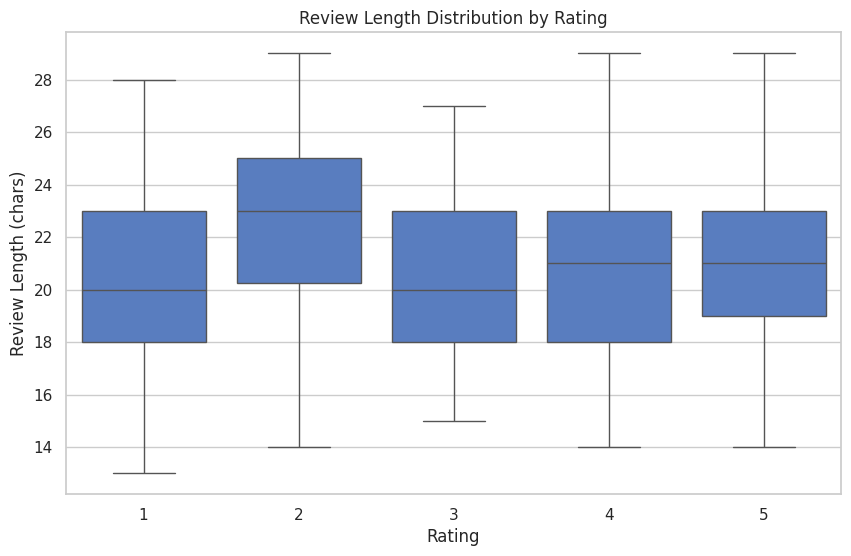

In [ ]:
# Cell 15: Review length boxplot per rating
plt.figure(figsize=(10,6))
sns.boxplot(data=df[df['rating']>0], x='rating', y='review_length')
plt.title('Review Length Distribution by Rating')
plt.xlabel('Rating')
plt.ylabel('Review Length (chars)')
plt.show()


Most mentioned words in 1-star reviews (bar chart)

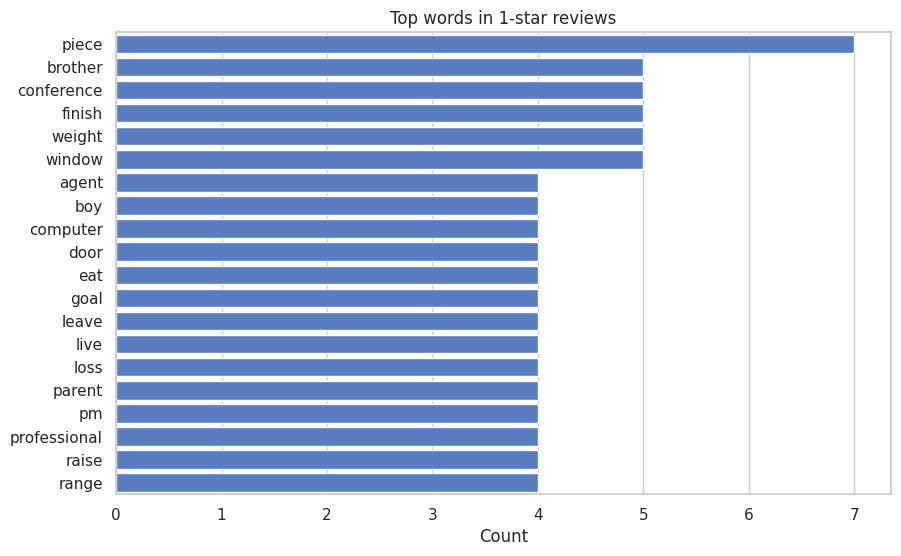

In [ ]:
# Cell 16: Top words in 1-star reviews
one_star = df[df['rating']==1]['clean_review'].dropna().str.cat(sep=' ')
vec = CountVectorizer(max_features=40).fit([one_star])
word_counts = vec.transform([one_star]).toarray().flatten()
words = vec.get_feature_names_out()
top = sorted(zip(words, word_counts), key=lambda x: x[1], reverse=True)[:20]
words_top, counts_top = zip(*top)

plt.figure(figsize=(10,6))
sns.barplot(x=list(counts_top), y=list(words_top))
plt.title('Top words in 1-star reviews')
plt.xlabel('Count')
plt.show()


Which ChatGPT version received highest avg rating

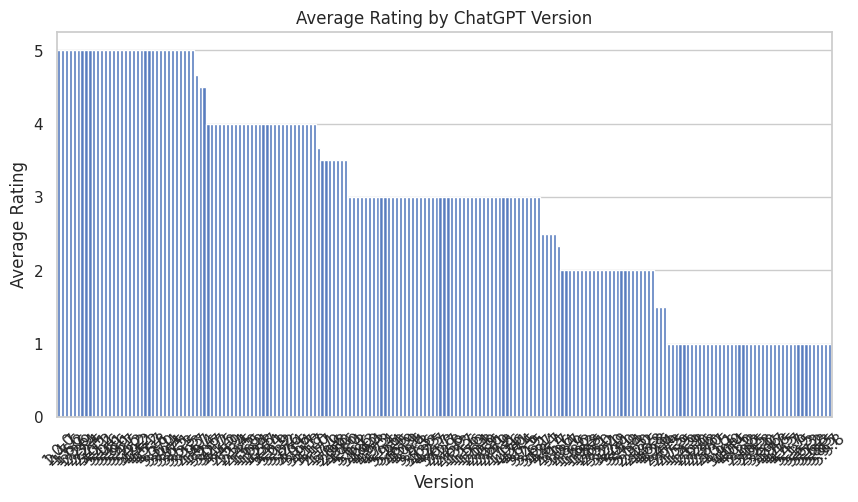

,version,count,mean
0,1.0.0,1,5.0
54,2.4.7,1,5.0
27,1.7.6,1,5.0
21,1.6.2,1,5.0
12,1.3.6,1,5.0
47,2.2.9,1,5.0
50,2.3.4,1,5.0
42,2.2.4,1,5.0
43,2.2.5,1,5.0
160,5.0.1,1,5.0


In [ ]:
# Cell 17: Avg rating by version
version_avg = df.groupby('version')['rating'].agg(['count','mean']).reset_index().sort_values('mean', ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(data=version_avg, x='version', y='mean')
plt.title('Average Rating by ChatGPT Version')
plt.xlabel('Version')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.show()
display(version_avg.head(20))


**Modeling — train a sentiment classifier (TF-IDF + LogisticRegression) and evaluate**

Create train/test splits

In [ ]:
# Cell 18: Prepare data for modeling
# We'll train to predict rating_sentiment (positive, neutral, negative) derived from rating
df_model = df[df['rating_sentiment'] != 'unknown'].copy()
X = df_model['clean_review']
y = df_model['rating_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (200,) Test: (50,)


Pipeline: TF-IDF + LogisticRegression, training + evaluation

Accuracy: 0.34
              precision    recall  f1-score   support

    negative       0.40      0.42      0.41        19
     neutral       0.23      0.25      0.24        12
    positive       0.35      0.32      0.33        19

    accuracy                           0.34        50
   macro avg       0.33      0.33      0.33        50
weighted avg       0.34      0.34      0.34        50



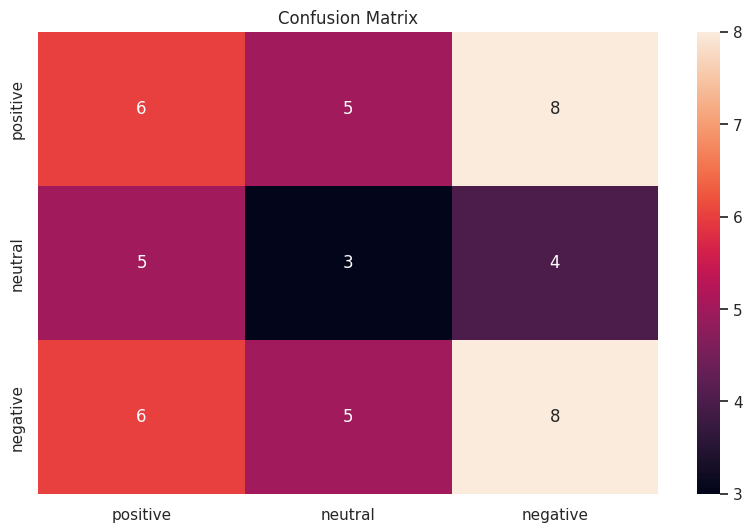

In [ ]:
# Cell 19: Train TF-IDF + LogisticRegression baseline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.9, min_df=5, ngram_range=(1,2))),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=['positive','neutral','negative'])
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['positive','neutral','negative'], yticklabels=['positive','neutral','negative'])
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Cell 20: Save trained pipeline and vectorizer/model
MODEL_PATH = '/content/sentiment_pipeline.joblib'
joblib.dump(pipeline, MODEL_PATH)
print("Saved model pipeline to:", MODEL_PATH)


Saved model pipeline to: /content/sentiment_pipeline.joblib


Sentence-BERT + XGBoost Sentiment Model

In [ ]:
# Cell 21: Train Sentence-BERT embeddings + XGBoost classifier


from sentence_transformers import SentenceTransformer
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Load sentence-transformer model
print("Loading Sentence-BERT model...")
model_sbert = SentenceTransformer('all-MiniLM-L6-v2')

# Encode training and test reviews
print("Encoding training and test data...")
X_train_emb = model_sbert.encode(X_train.tolist(), show_progress_bar=True, batch_size=64)
X_test_emb = model_sbert.encode(X_test.tolist(), show_progress_bar=True, batch_size=64)

# Encode sentiment labels numerically
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Train XGBoost model
print("Training XGBoost classifier...")
clf_xgb = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_),
    eval_metric='mlogloss',
    learning_rate=0.1,
    max_depth=6,
    n_estimators=200,
    random_state=42,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
)
clf_xgb.fit(X_train_emb, y_train_enc)

# Predict on test data
y_pred_xgb = clf_xgb.predict(X_test_emb)
acc = accuracy_score(y_test_enc, y_pred_xgb)
print(f"✅ XGBoost (SBERT) Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred_xgb, target_names=le.classes_))

# Save both models and label encoder
joblib.dump({
    "sbert_model": model_sbert,
    "xgb_model": clf_xgb,
    "label_encoder": le
}, "/content/xgb_sbert_model_bundle.joblib")

print("✅ Model bundle saved to /content/xgb_sbert_model_bundle.joblib")


Loading Sentence-BERT model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Encoding training and test data...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Training XGBoost classifier...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [10:11:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost (SBERT) Accuracy: 0.4200

Classification Report:
              precision    recall  f1-score   support

    negative       0.48      0.63      0.55        19
     neutral       0.20      0.08      0.12        12
    positive       0.40      0.42      0.41        19

    accuracy                           0.42        50
   macro avg       0.36      0.38      0.36        50
weighted avg       0.38      0.42      0.39        50

✅ Model bundle saved to /content/xgb_sbert_model_bundle.joblib


In [ ]:
# Test a new review using SBERT+XGBoost model
bundle = joblib.load("/content/xgb_sbert_model_bundle.joblib")
model_sbert = bundle["sbert_model"]
clf_xgb = bundle["xgb_model"]
le = bundle["label_encoder"]

sample = ["I love this red color, the manager concern responses are amazing and fast!"]
emb = model_sbert.encode(sample)
pred = clf_xgb.predict(emb)
print("Predicted sentiment:", le.inverse_transform(pred)[0])


Predicted sentiment: neutral


Topic modeling for negative reviews (to identify negative themes)
LDA on negative reviews

In [ ]:
# Cell 22: Topic modeling (LDA) on negative reviews - use CountVectorizer + sklearn LDA
from sklearn.decomposition import LatentDirichletAllocation

neg_reviews = df[df['rating_sentiment']=='negative']['clean_review'].dropna()
cv = CountVectorizer(max_df=0.95, min_df=5, stop_words='english')
X_cv = cv.fit_transform(neg_reviews)

n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X_cv)

def show_topics(model, feature_names, n_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        topics.append((topic_idx, top_features))
    return topics

topics = show_topics(lda, cv.get_feature_names_out(), 10)
for t in topics:
    print(f"Topic {t[0]}: {', '.join(t[1])}")


Topic 0: piece, weight, mind, hair, debate, decision, allow, recently, mr, pm
Topic 1: brother, friend, participant, throw, conference, central, usually, fact, mission, beat
Topic 2: loss, finish, vote, tree, improve, require, mr, guess, recently, western
Topic 3: short, leave, goal, best, group, list, truth, mission, western, picture
Topic 4: eat, know, question, environment, practice, allow, beat, truth, fact, central


Streamlit app

In [ ]:
# Cell 23: Build Streamlit dashboard app.py

streamlit_code = r'''
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

st.set_page_config(layout="wide", page_title="ChatGPT Reviews Sentiment Dashboard")

@st.cache_data
def load_data(path):
    df = pd.read_csv(path)
    return df

@st.cache_resource
def load_model(path):
    model = joblib.load(path)
    return model

# Paths (adjust if needed)
DATA_PATH = "clean_chatgpt_reviews.csv"
MODEL_PATH = "sentiment_pipeline.joblib"

# Load data and model
df = load_data(DATA_PATH)
model = load_model(MODEL_PATH)

st.title("🤖 ChatGPT Reviews - Sentiment Insights Dashboard")

# Sidebar filters
st.sidebar.header("🔍 Filters")
platforms = st.sidebar.multiselect(
    "Select Platform(s):", options=df["platform"].unique().tolist(),
    default=df["platform"].unique().tolist()
)
locations = st.sidebar.multiselect(
    "Select Locations (Top 20):",
    options=df["location"].value_counts().index[:20].tolist(),
    default=df["location"].value_counts().index[:10].tolist()
)
helpful_min = st.sidebar.slider("Minimum Helpful Votes:", 0, int(df["helpful_votes"].max()), 0)

# Apply filters
filtered_df = df[
    (df["platform"].isin(platforms)) &
    (df["location"].isin(locations)) &
    (df["helpful_votes"] >= helpful_min)
]

st.markdown("### 📊 Overview Metrics")
col1, col2, col3 = st.columns(3)
col1.metric("Total Reviews", len(filtered_df))
col2.metric("Average Rating", round(filtered_df["rating"].mean(), 2))
col3.metric("Verified Users (%)", round((filtered_df["verified_purchase"] == "Yes").mean() * 100, 2))

# --- Rating Distribution ---
st.markdown("### ⭐ Rating Distribution")
fig1, ax1 = plt.subplots(figsize=(8,4))
sns.countplot(data=filtered_df, x="rating", ax=ax1, palette="viridis", order=sorted(filtered_df["rating"].unique()))
ax1.set_title("Distribution of Ratings (1–5)")
st.pyplot(fig1)

# --- Sentiment Distribution ---
st.markdown("### 💬 Sentiment Distribution (Based on Rating Category)")
sent_counts = filtered_df["rating_sentiment"].value_counts(normalize=True).mul(100).reset_index()
sent_counts.columns = ["Sentiment", "Percentage"]

fig2, ax2 = plt.subplots(figsize=(6,4))
sns.barplot(data=sent_counts, x="Sentiment", y="Percentage", ax=ax2, palette="coolwarm")
ax2.set_title("Sentiment Split (%)")
st.pyplot(fig2)

# --- Average Rating by Platform ---
st.markdown("### 🧩 Average Rating by Platform")
avg_platform = filtered_df.groupby("platform")["rating"].mean().reset_index()
fig3, ax3 = plt.subplots(figsize=(8,4))
sns.barplot(data=avg_platform, x="platform", y="rating", ax=ax3, palette="mako")
ax3.set_title("Average Rating by Platform")
st.pyplot(fig3)

# --- Average Rating by Version ---
st.markdown("### 🧠 Average Rating by ChatGPT Version")
avg_version = filtered_df.groupby("version")["rating"].mean().reset_index().sort_values(by="rating", ascending=False)
fig4, ax4 = plt.subplots(figsize=(10,4))
sns.barplot(data=avg_version, x="version", y="rating", ax=ax4, palette="rocket")
ax4.set_title("Average Rating by ChatGPT Version")
ax4.tick_params(axis='x', rotation=45)
st.pyplot(fig4)

# --- Predict Sentiment for Custom Review ---
st.markdown("### 🔮 Try It Yourself: Predict Sentiment from Text")
user_input = st.text_area("Enter a review to analyze sentiment:")
if st.button("Predict Sentiment"):
    if user_input.strip():
        pred = model.predict([user_input])[0]
        st.success(f"Predicted Sentiment: **{pred.upper()}**")
    else:
        st.warning("Please enter some text before predicting.")

# Footer
st.markdown("---")
st.caption("Developed by Nandy | Sentiment Analysis Project | Powered by Streamlit + Scikit-Learn")
'''

# Write to app.py
with open('app.py', 'w') as f:
    f.write(streamlit_code)

print("✅ Streamlit app written successfully to app.py")
print("To run locally: streamlit run app.py")


✅ Streamlit app written successfully to app.py
To run locally: streamlit run app.py
